# Pulses Of Light
## Introduction
We have already had a look at how constant E field interact with a three level atom showing the susceptability, $\chi$, and *slow light*. Now we will look at how pulses of the probe beam interact with the atom and end up at *pulse distortion*. 


## Theory
suppose the material has a length, $L$, the wavefunction at the input face, $z=0$, can be written as
$$
\vec{E}(z,t) = \hat{e}\int_{-\infty}^\infty d\omega e^{-i\omega(t-z/c)}E(\omega) +c
$$
After light passes through the material at coordinate $z=L$, the equation is given by

$$
\vec{E}(L,t) = \hat{e}T(t) +c
$$

$$
T(t) = \int_{-\infty}^\infty dw e^{-i\omega t + i\frac{\omega n(\omega)L}{c}} E(\omega)
$$
We can relate $n$ to $\chi$ by the relation, $n = \sqrt{1+\chi} \approx 1 + \frac{\chi_R + \chi_I}{2}$

## Imports

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import numpy as np
from scipy.optimize import curve_fit
from scipy.constants import c, e, hbar
from qutip import *
import matplotlib.patches as mpatches
from scipy import signal
from arc import *
from scipy.fft import fft, ifft, fftfreq, irfft
from scipy.integrate import quad

%matplotlib inline

C:\Users\A_SAU\Anaconda3\envs\Rydberg\lib\site-packages\qutip\__init__.py:65: UserWarning: The new version of Cython, (>= 3.0.0) is not supported.
  warnings.warn(



## Generating Pulse

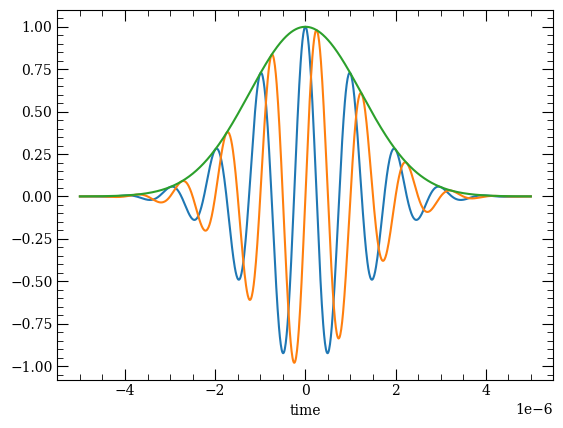

C:\Users\A_SAU\Anaconda3\envs\Rydberg\lib\site-packages\matplotlib\cbook\__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


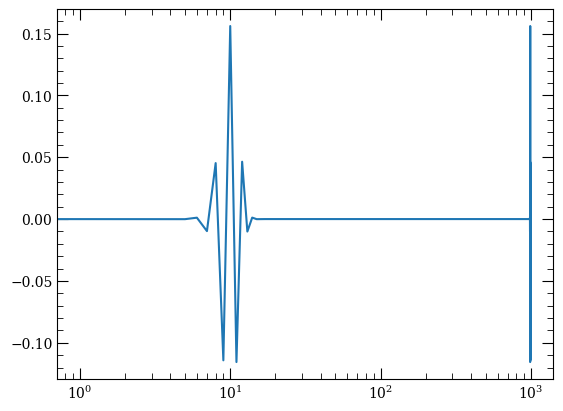

In [3]:
N = 1000
T = 1E-5

times = np.linspace(-T/2,T/2,N)

gaus_sig,imag_gaus,y_env = signal.gausspulse(times,fc = 1E6, bw = 0.3,retquad=True,retenv=True)
freq = ifft(gaus_sig)

plt.plot(times,gaus_sig)
plt.plot(times,imag_gaus)
plt.plot(times,y_env)
plt.xlabel("time")
plt.show()

plt.plot(freq)
plt.xscale('log')

## Setting up Rydberg Atom

In [37]:
rabi_probe = 0.001
rabi_couple = 0.5
detune_probe = 0.5
detune_couple = 0
gamma_b = 1
gamma_c = 1E-6

# freq = 10* rabi_probe
# wave_vec = 2*np.pi/freq

atom = Rubidium(preferQuantumDefects =False)
level = atom.getEnergy(atom.groundStateN,1,0.5)-atom.getEnergy(atom.groundStateN,0,0.5)
omega_eg = level*e/hbar/1E6

print(omega_eg)

#signal params
tau = 10E-6
slope = tau*2
gradient = rabi_probe/slope

2369435883.882498


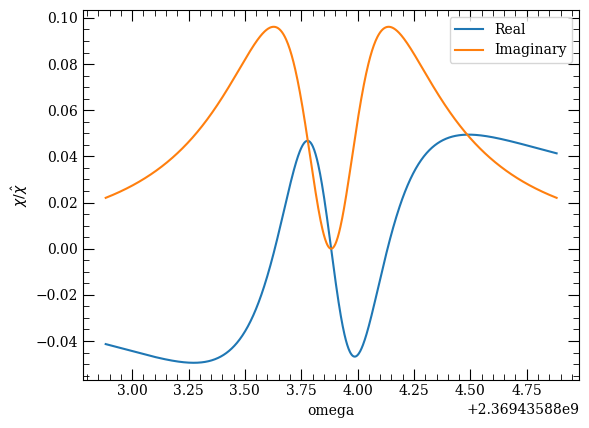

In [28]:
detuning_eg = np.linspace(-1,1,1000)
psi0 = (basis(3,0)*2+basis(3, 1)).unit()
c_ops = [np.sqrt(gamma_b)*(qutip.three_level_atom.three_level_ops()[3]),np.sqrt(gamma_c)*qutip.three_level_atom.three_level_ops()[4]]
e_ops = [np.sqrt(2)*jmat(1,'x'),np.sqrt(2)*jmat(1,'y'),2*jmat(1,'z')-1]
real = []
imag=[]
chi = []

for detune in detuning_eg:
    H = 0.5*Qobj(np.array([[0,rabi_probe,0],[rabi_probe,-2*detune,rabi_couple],[0,rabi_couple,-2*(detune-detune_couple)]]))
    # H2 = 0.5*Qobj(np.array([[0,rabi_probe,0],[rabi_probe,-2*detune,1E-6],[0,1E-6,-2*(detune-detune_couple)]]))
    result = steadystate(H, c_ops)
    chi.append(result[0,1])
    real.append(result[0,1].real)
    imag.append(result[0,1].imag)


frequencies = detuning_eg+omega_eg

plt.plot(frequencies, real, label = 'Real')
plt.plot(frequencies, imag, label = 'Imaginary')
plt.legend()
plt.xlabel('omega')
plt.ylabel('$\chi/\hat{\chi}$')


# if save:
#     plt.savefig(str("probe-"+str(rabi_probe)+"_"+str(detune_probe)+"_couple-"+str(rabi_couple)+"_"+str(detune_couple)+"_gamma(b_c)-"+str(gamma_b)+"_"+str(gamma_c)+".svg"))
#     # plt.savefig("plot.svg")

plt.show()

## Plotting optical density

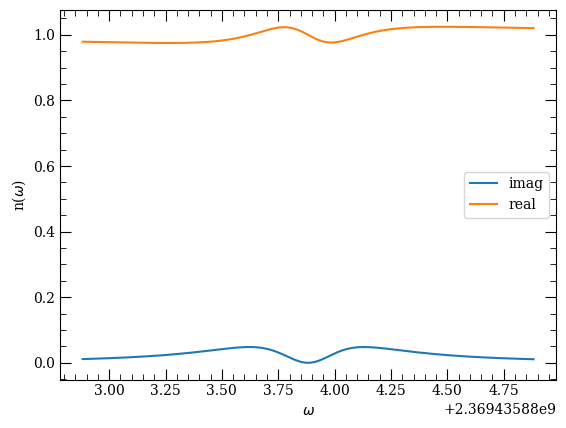

In [29]:
chi = np.array(chi)
optical_density = np.sqrt(1+chi)
plt.plot(frequencies, optical_density.imag,  label = "imag")
plt.plot(frequencies, optical_density.real, label = "real")
plt.ylabel('n($\omega$)')
plt.xlabel('$\omega$')
plt.legend()


In [30]:
# chi = np.array(chi)
# optical_density = 1+chi/2
# plt.plot(detuning_eg/gamma_b, optical_density.imag, label = "iamg")
# plt.plot(detuning_eg/gamma_b, optical_density.real, label = "real")
# plt.legend()
min(optical_density.imag)

2.963320633075687e-06

Finding the propagated wave
$$
\vec{E}(L,t) = \hat{e}T(t) +const
$$

$$
T(t) = \int_{-\infty}^\infty dw e^{-i\omega t + i\frac{\omega n(\omega)L}{c}} E(\omega)
$$

C:\Users\A_SAU\Anaconda3\envs\Rydberg\lib\site-packages\matplotlib\cbook\__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


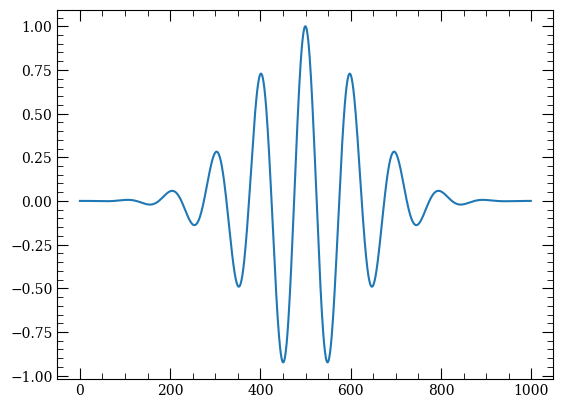

In [31]:
L = 1 # sample length in m
omega = np.linspace(0,1E6,len(optical_density))
transmission_pulse = fft(freq*np.exp(1j*(optical_density)*L/c))
# plt.plot(transmission_pulse.real[0:10])
# plt.plot(transmission_pulse.imag)

plt.plot(transmission_pulse)
# plt.plot(gaus_sig)
# plt.xscale('log')
# plt.yscale('log')

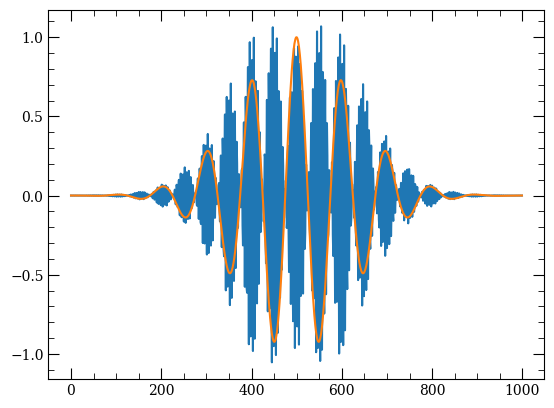

In [32]:
transmission = []
test = []
for i in range(len(frequencies)):
    omega = frequencies[i]
    transmission.append(np.exp(-1j*omega*times[i]+1j*omega*optical_density[i].real*L/c)*gaus_sig[i]*np.exp(omega*optical_density[i].imag*L/c))
    # test.append(np.exp(-1j*omega*times[i])*gaus_sig[i])


plt.plot(transmission)
plt.plot(gaus_sig)
# plt.plot(test)

(1000,)

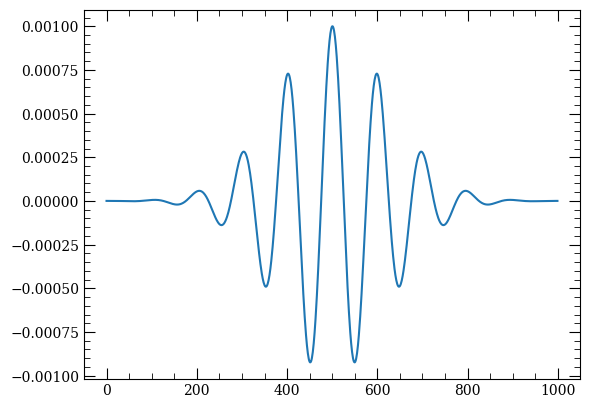

In [33]:
def trans_pulse(omega, t):
    gaus_sig*np.exp(-1j*omega(t-optical_density*L/c))

delta_t = times[1]-times[0]
n=len(times)
out = []                    
for i in range(len(times)):
    out.append(np.sum(freq * np.exp(2j * np.pi * (i-optical_density*L/c) * np.arange(n)/n)) / len(freq))

plt.plot(out)
np.shape(optical_density)

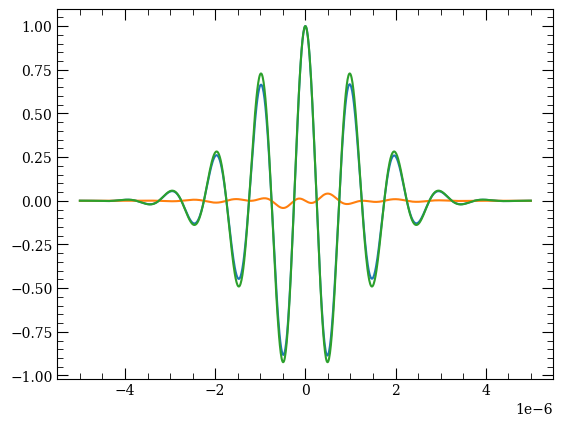

In [36]:
trans = np.exp(1j * optical_density * chi* L) * gaus_sig
plt.plot(times,trans.real)
plt.plot(times,trans.imag)
plt.plot(times,gaus_sig)

In [26]:
np.exp(1j * optical_density * chi* L)

array([0.99778863-4.13673831e-03j, 0.99778083-4.14194002e-03j,
       0.99777299-4.14714653e-03j, 0.99776511-4.15235775e-03j,
       0.99775718-4.15757363e-03j, 0.99774922-4.16279406e-03j,
       0.99774122-4.16801897e-03j, 0.99773318-4.17324828e-03j,
       0.9977251 -4.17848190e-03j, 0.99771697-4.18371974e-03j,
       0.99770881-4.18896172e-03j, 0.9977006 -4.19420774e-03j,
       0.99769235-4.19945772e-03j, 0.99768406-4.20471155e-03j,
       0.99767573-4.20996915e-03j, 0.99766735-4.21523041e-03j,
       0.99765893-4.22049524e-03j, 0.99765047-4.22576354e-03j,
       0.99764197-4.23103520e-03j, 0.99763342-4.23631013e-03j,
       0.99762483-4.24158821e-03j, 0.99761619-4.24686933e-03j,
       0.99760751-4.25215340e-03j, 0.99759878-4.25744029e-03j,
       0.99759001-4.26272989e-03j, 0.99758119-4.26802209e-03j,
       0.99757233-4.27331676e-03j, 0.99756342-4.27861379e-03j,
       0.99755447-4.28391306e-03j, 0.99754547-4.28921444e-03j,
       0.99753642-4.29451781e-03j, 0.99752732-4.2998230

## Making the Pulse
We will start with a Gaussian pulse

# Gaussian

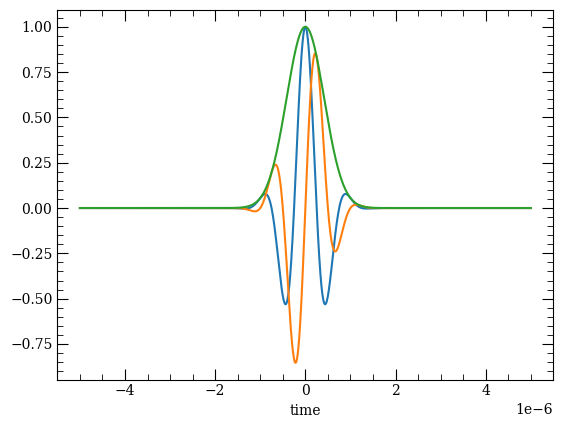

In [10]:
N = 1000
T = 1E-5

times = np.linspace(-T/2,T/2,N)

gaus_sig,imag_gaus,y_env = signal.gausspulse(times,fc = 1E6, bw = 0.9,retquad=True,retenv=True)
# freq = fft(gaus_sig)

plt.plot(times,gaus_sig)
plt.plot(times,imag_gaus)
plt.plot(times,y_env)
plt.xlabel("time")
plt.show()

## Fourier Analysis

Here we break down the pulse into its frequencies and analyse how it passes through the EIT at each frequency

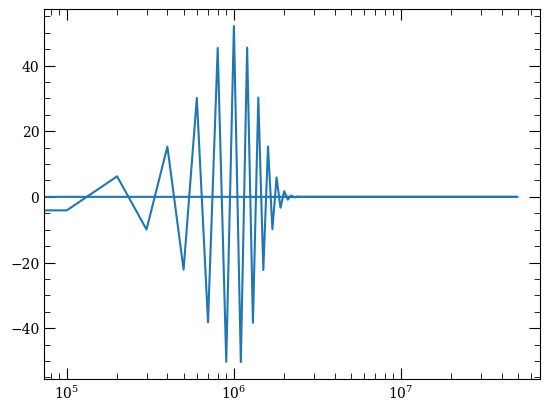

In [11]:
freq = fftfreq(N,T/N)
yf = (fft(gaus_sig))

plt.xscale('log')
plt.plot(freq,yf)


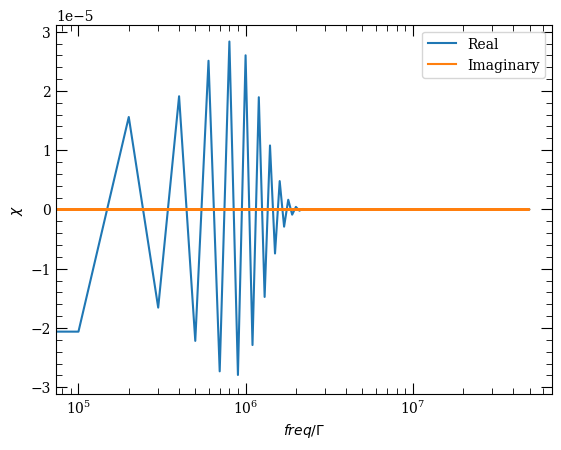

In [12]:
chi = []
real = []
imag= []


for i in range(len(freq)):
    H = 0.5*Qobj(np.array([[0,yf[i],0],[yf[i],-2*freq[i],rabi_couple],[0,rabi_couple,-2*(freq[i]-detune_couple)]]))
    # H2 = 0.5*Qobj(np.array([[0,rabi_probe,0],[rabi_probe,-2*detune,1E-6],[0,1E-6,-2*(detune-detune_couple)]]))
    result = steadystate(H, c_ops)
    chi.append(result[0,1])
    real.append(result[0,1].real)
    imag.append(result[0,1].imag)

plt.plot(freq, real, label = 'Real')
plt.plot(freq, imag, label = 'Imaginary')
plt.legend()
plt.xlabel('$freq/\Gamma$')
plt.ylabel('$\chi$')

# if save:
#     plt.savefig(str("probe-"+str(rabi_probe)+"_"+str(detune_probe)+"_couple-"+str(rabi_couple)+"_"+str(detune_couple)+"_gamma(b_c)-"+str(gamma_b)+"_"+str(gamma_c)+".svg"))
#     # plt.savefig("plot.svg")
plt.xscale('log')
plt.show()

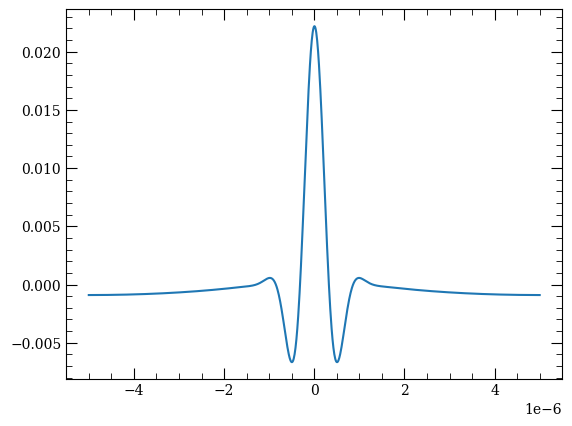

In [13]:
plt.plot(times,irfft(real/max(real), len(times)))
# plt.xlim(900,1100)

In [ ]:
np.shape(freq)

# Dispersion
Related to the wavevector, $k$, and high orders of it.


$$
1+\chi = n^2 = (c/v)^2 = \frac{c^2}{\omega^2}k^2
$$

In [ ]:
real = np.array(real)
imag = np.array(imag)
chi = np.array(chi)

dchi = np.gradient(real, detuning_eg/gamma_b)
d2chi = np.gradient(dchi,detuning_eg/gamma_b)

denom = 1+real/2+(omega_eg-detuning_eg)*dchi/2
# plt.plot(detuning_eg, denom)
v_g = c/denom
k_2 = (d2chi*(1+chi)**-0.5)/2-(dchi*(1+chi)**-1.5)/4

plt.plot(detuning_eg, k_2.real)
# plt.plot(detuning_eg, k_2.imag)

In [ ]:
z=1

sigma = (t_0**2 + ((k_2*z)/t_0)**2)**0.5



# Dispersion

In [ ]:
t_0 = 1.2

(t_0**2 + ((k_2*z)/t_0)**2)**0.5

In [ ]:


def trapzoid_signal(t, args):
    slope = args['slope']
    amp = args['A']
    width = args['width']
    offs = args['offs']
    a = slope*width*signal.sawtooth(2*np.pi*t/width, width=0.5)/4
    a[a>amp/2.] = amp/2.
    a[a<-amp/2.] = -amp/2.
    return a + amp/2. + offs

def get_trap(t,args):
    times = np.linspace(0,1E-4,1000)
    trap = trapzoid_signal(times,args)
    index = np.where(times == t)
    return trap[index]

args = {'A': rabi_probe, 'slope': gradient, 'width': 1E-4, 'offs': 0}
plt.plot(times,trapzoid_signal(times,args))

In [ ]:
H0 = 0.5*Qobj(np.array([[0,rabi_probe,0],[rabi_probe,-2*detune_probe,rabi_couple],[0,rabi_couple,-2*(detune_probe-detune_couple)]]))
H1 = 0.5*Qobj(np.array([[0,1,0],[1,0,0],[0,0,0]]))
H = [H0, [H1, get_trap]]
psi0 = (basis(3,0)).unit()
c_ops = [np.sqrt(gamma_b)*(qutip.three_level_atom.three_level_ops()[3].dag()),np.sqrt(gamma_c)*qutip.three_level_atom.three_level_ops()[4].dag()]
e_ops = [np.sqrt(2)*jmat(1,'x'),np.sqrt(2)*jmat(1,'y'),2*jmat(1,'z')-1]


In [ ]:
args['width']

In [ ]:
args = {'A': rabi_probe, 'slope': gradient, 'width': 1E-4, 'offs': 0}

result_me = mesolve(H, psi0, times, c_ops, e_ops, args=args)


In [ ]:
plot_expectation_values(
    [result_me], ylabels=["<X>", "<Y>", "<Z>"], show_legend=True
);